# Basic training functionality

In [ ]:
from fastai.basic_train import *
from fastai.gen_doc.nbdoc import *
from fastai import *
from fastai.vision import *
from fastai.docs import *

`basic_train` wraps together the data (in a `DataBunch` object) with a pytorch model to define a `Learner` object. This is where the basic training loop is defined for the `fit` function. The `Learner` object is the entry point of most of the `Callback` functions that will customize this training loop in different ways (and made available through the `train` module), notably:

 - `Learner.lr_find` will launch an LR range test that will help you select a good learning rate
 - `Learner.fit_one_cycle` will launch a training using the 1cycle policy, to help you train your model fast.
 - `Learner.to_fp16` will convert your model in half precision and halp you launch a training in mixed precision.

In [ ]:
show_doc(Learner, title_level=2)

## <a id=Learner></a>`class` `Learner`
> `Learner`(`data`:[`DataBunch`](/data.html#DataBunch), `model`:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), `opt_fn`:`Callable`=`'Adam'`, `loss_fn`:`Callable`=`'cross_entropy'`, `metrics`:`Collection`\[`Callable`\]=`None`, `true_wd`:`bool`=`True`, `bn_wd`:`bool`=`True`, `wd`:`Floats`=`0.01`, `train_bn`:`bool`=`True`, `path`:`str`=`None`, `model_dir`:`str`=`'models'`, `callback_fns`:`Collection`\[`Callable`\]=`None`, `callbacks`:`Collection`\[[`Callback`](/callback.html#Callback)\]=`<factory>`, `layer_groups`:`ModuleList`=`None`)


Train `model` using `data` to minimize `loss_fn` with optimizer `opt_fn`. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L90">[source]</a>

The main purpose of `Learner` is to train `model` using `Learner.fit`. After every epoch, all *metrics* will be printed, and will also be available to callbacks.

The default weight decay will be `wd`, which will be handled using the method from [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101) if `true_wd` is set (otherwise it's L2 regularization). If `bn_wd` is False then weight decay will be removed from batchnorm layers, as recommended in [Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour](https://arxiv.org/abs/1706.02677). You can also turn off batchnorm layer training entirely (i.e. freeze all batchnorm learnable parameters) by disabling `train_bn`.

To use [discriminative layer training](#discriminative) pass an `nn.Module` for each layer group to be optimized with different settings.

Any model files created will be saved in `path`/`model_dir`.

You can pass a list of `callbacks` that you have already created, or (more commonly) simply pass a list of callback functions to `callback_fns` and each function will be called (passing `self`) on object initialization, with the results stored as callback objects. For a walk-through, see the [training overview](/training.html) page. You may also want to use an `application` to fit your model, e.g. using the `ConvLearner` subclass:

In [ ]:
data = get_mnist()
learn = ConvLearner(data, tvm.resnet18, metrics=accuracy)
learn.fit(1)

Total time: 00:05
epoch  train loss  valid loss  accuracy
0      0.086652    0.038705    0.986261  (00:05)



### Model fitting methods

In [ ]:
show_doc(Learner.fit)

#### <a id=fit></a>`fit`
> `fit`(`epochs`:`int`, `lr`:`Union`\[`float`, `Collection`\[`float`\], `slice`\]=`slice(None, 0.003, None)`, `wd`:`Floats`=`None`, `callbacks`:`Collection`\[[`Callback`](/callback.html#Callback)\]=`None`)


Fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L125">[source]</a>

Uses [discriminative layer training](#discriminative) if multiple learning rates or weight decay values are passed. To control training behaviour, use the `callback` system or one or more of the pre-defined `callbacks`.

In [ ]:
show_doc(Learner.fit_one_cycle)

#### <a id=fit_one_cycle></a>`fit_one_cycle`
> `fit_one_cycle`(`learn`:[`Learner`](/basic_train.html#Learner), `cyc_len`:`int`, `max_lr`:`Union`\[`float`, `Collection`\[`float`\], `slice`\]=`slice(None, 0.003, None)`, `moms`:`Point`=`(0.95, 0.85)`, `div_factor`:`float`=`25.0`, `pct_start`:`float`=`0.3`, `wd`:`float`=`None`, `kwargs`)


Fit a model following the 1cycle policy. <a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L11">[source]</a>

Uses the `OneCycleScheduler` callback.

In [ ]:
show_doc(Learner.lr_find)

#### <a id=lr_find></a>`lr_find`
> `lr_find`(`learn`:[`Learner`](/basic_train.html#Learner), `start_lr`:`float`=`1e-05`, `end_lr`:`float`=`10`, `num_it`:`int`=`100`, `kwargs`:`Any`)


Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. <a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L20">[source]</a>

Runs the learning rate finder defined in `LRFinder`, as discussed in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). 

### Mixed precision training

In [ ]:
show_doc(Learner.to_fp16)

#### <a id=to_fp16></a>`to_fp16`
> `to_fp16`(`learn`:[`Learner`](/basic_train.html#Learner), `loss_scale`:`float`=`512.0`, `flat_master`:`bool`=`False`) -> [`Learner`](/basic_train.html#Learner)


Transform `learn` in FP16 precision. <a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L26">[source]</a>

Uses the `MixedPrecision` callback to train in mixed precision (i.e. forward and backward passes using fp16, with weight updates using fp32), using all [NVIDIA recommendations](https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html) for ensuring speed and accuracy.

### Discriminative layer training

When fitting a model you can pass a list of learning rates (and/or weight decay amounts), which will apply a different rate to each *layer group* (i.e. the parameters of each module in `self.layer_groups`). See the [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146) paper for details and experimental results in NLP (we also frequently use them successfully in computer vision, but have not published a paper on this topic yet). When working with a `Learner` on which you've called `split`, you can set hyperparameters in four ways:

1. `param = [val1, val2 ..., valn]` (n = number of layer groups)
2. `param = val`
3. `param = slice(start,end)`
4. `param = slice(end)`

If we chose to set it in way 1, we must specify a number of values exactly equal to the number of layer groups. If we chose to set it in way 2, the chosen value will be repeated for all layer groups. See `Learner.lr_range` for an explanation of the `slice` syntax).

Here's an example of how to use discriminative learning rates (note that you don't actually need to manually call `Learner.split` in this case, since fastai uses this exact function as the default split for `resnet18`; this is just to show how to customize it):

In [ ]:
# creates 3 layer groups
learn.split(lambda m: (m[0][6], m[1]))
# only randomly initialized head now trainable
learn.freeze()

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:04
epoch  train loss  valid loss  accuracy
0      0.040739    0.029042    0.992640  (00:04)



In [ ]:
# all layers now trainable
learn.unfreeze()
# optionally, separate LR and WD for each group
learn.fit_one_cycle(1, max_lr=(1e-4, 1e-3, 1e-2), wd=(1e-4,1e-4,1e-1))

Total time: 00:05
epoch  train loss  valid loss  accuracy
0      0.023351    0.017301    0.995093  (00:05)



In [ ]:
show_doc(Learner.lr_range)

#### <a id=lr_range></a>`lr_range`
> `lr_range`(`lr`:`Union`\[`float`, `slice`\]) -> `ndarray`


Build differential learning rates. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L118">[source]</a>

Rather than manually setting an LR for every group, it's often easier to use `Learner.lr_range`. This is a convenience method that returns one learning rate for each layer group. If you pass `slice(start,end)` then the first group's learning rate is `start`, the last is `end`, and the remaining are evenly geometrically spaced.

If you pass just `slice(end)` then the last group's learning rate is `end`, and all the other groups are `end/3`. For instance (for our learner that has 3 layer groups):

In [ ]:
learn.lr_range(slice(1e-5,1e-3)), learn.lr_range(slice(3e-4))

(array([1.e-05, 1.e-04, 1.e-03]), array([1.e-04, 1.e-04, 3.e-04]))

In [ ]:
show_doc(Learner.unfreeze)

#### <a id=unfreeze></a>`unfreeze`
> `unfreeze`()


Unfreeze entire model. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L156">[source]</a>

Sets every layer group to *trainable* (i.e. `requires_grad=True`).

In [ ]:
show_doc(Learner.freeze)

#### <a id=freeze></a>`freeze`
> `freeze`()


Freeze up to last layer. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L151">[source]</a>

Sets every layer group except the last to *untrainable* (i.e. `requires_grad=False`).

In [ ]:
show_doc(Learner.freeze_to)

#### <a id=freeze_to></a>`freeze_to`
> `freeze_to`(`n`:`int`)


Freeze layers up to layer `n`. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L144">[source]</a>

In [ ]:
show_doc(Learner.split)

#### <a id=split></a>`split`
> `split`(`split_on`:`SplitFuncOrIdxList`)


Split the model at `split_on`. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L139">[source]</a>

A convenience method that sets `layer_groups` based on the result of `split_model`. If `split_on` is a function, it calls that function and passes the result to `split_model` (see above for example).

### Saving and loading models

Simply call `Learner.save` and `Learner.load` to save and load models. Only the parameters are saved, not the actual architecture (so you'll need to create your model in the same way before loading weights back in). Models are saved to the `path`/`model_dir` directory.

In [ ]:
show_doc(Learner.load)

#### <a id=load></a>`load`
> `load`(`name`:`PathOrStr`)


Load model `name` from `self.model_dir`. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L166">[source]</a>

In [ ]:
show_doc(Learner.save)

#### <a id=save></a>`save`
> `save`(`name`:`PathOrStr`)


Save model with `name` to `self.model_dir`. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L162">[source]</a>

### Other methods

In [ ]:
show_doc(Learner.init)

#### <a id=init></a>`init`
> `init`(`init`)
<a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L116">[source]</a>

Initializes all weights (except batchnorm) using function `init`, which will often be from PyTorch's `nn.init` module.

In [ ]:
show_doc(Learner.mixup)

#### <a id=mixup></a>`mixup`
> `mixup`(`learn`:[`Learner`](/basic_train.html#Learner), `alpha`:`float`=`0.4`, `stack_x`:`bool`=`False`, `stack_y`:`bool`=`True`) -> [`Learner`](/basic_train.html#Learner)


Add mixup https://arxiv.org/abs/1710.09412 to `learn`. <a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L33">[source]</a>

Uses `MixUpCallback`.

In [ ]:
show_doc(Learner.pred_batch)

#### <a id=pred_batch></a>`pred_batch`
> `pred_batch`(`learn`:[`Learner`](/basic_train.html#Learner), `is_valid`:`bool`=`True`) -> `Tuple`\[`Tensors`, `Tensors`, `Tensors`\]


Returns input, target and output of the model on a batch <a href="https://github.com/fastai/fastai/blob/master/fastai/tta.py#L8">[source]</a>

Get the first batch of predictions. Mainly useful for debugging and quick tests.

In [ ]:
show_doc(Learner.create_opt)

#### <a id=create_opt></a>`create_opt`
> `create_opt`(`lr`:`Floats`, `wd`:`Floats`=`0.0`)


Create optimizer with `lr` learning rate and `wd` weight decay. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L135">[source]</a>

You generally won't need to call this yourself - it's used to create the `nn.optim` optimizer before fitting the model.

In [ ]:
show_doc(Recorder, title_level=2)

## <a id=Recorder></a>`class` `Recorder`
> `Recorder`(`learn`:[`Learner`](/basic_train.html#Learner)) :: [`LearnerCallback`](/basic_train.html#LearnerCallback)


A [`LearnerCallback`](/basic_train.html#LearnerCallback) that records epoch, loss, opt and metric data during training. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L180">[source]</a>

A `Learner` creates a `Recorder` object automatically - you do not need to explicitly pass to `callback_fns` - because other callbacks rely on it being available. It stores the smoothed loss, hyperparameter values, and metrics each batch, and provides plotting methods for each. Note that `Learner` automatically sets an attribute with the snake-cased name of each callback, so you can access this through `Learner.recorder`, as shown below.

### Plotting methods

In [ ]:
show_doc(Recorder.plot)

#### <a id=plot></a>`plot`
> `plot`(`skip_start`:`int`=`10`, `skip_end`:`int`=`5`)


Plot learning rate and losses, trimmed between `skip_start` and `skip_end`. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L234">[source]</a>

This is mainly used with the learning rate finder, since it shows a scatterplot of loss vs learning rate.

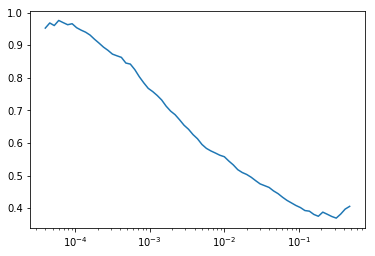

In [ ]:
learn = ConvLearner(data, tvm.resnet18, metrics=accuracy)
learn.lr_find()
learn.recorder.plot()

In [ ]:
show_doc(Recorder.plot_losses)

#### <a id=plot_losses></a>`plot_losses`
> `plot_losses`()


Plot training and validation losses. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L242">[source]</a>

Note that validation losses are only calculated once per epoch, whereas training losses are calculated after every batch.

Total time: 00:09
epoch  train loss  valid loss  accuracy
0      0.113814    0.065617    0.980373  (00:04)
1      0.046937    0.040896    0.988224  (00:04)



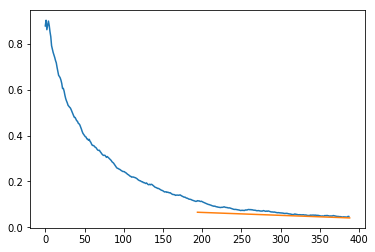

In [ ]:
learn.fit_one_cycle(2)
learn.recorder.plot_losses()

In [ ]:
show_doc(Recorder.plot_lr)

#### <a id=plot_lr></a>`plot_lr`
> `plot_lr`(`show_moms`=`False`)


Plot learning rate, `show_moms` to include momentum. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L225">[source]</a>

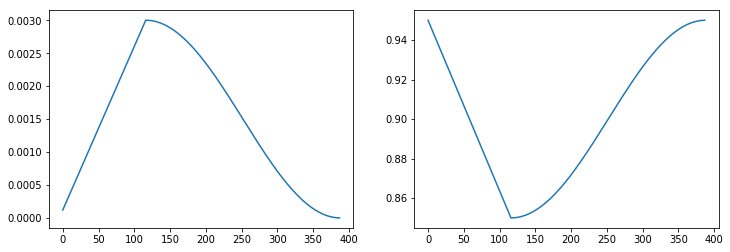

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
show_doc(Recorder.plot_metrics)

#### <a id=plot_metrics></a>`plot_metrics`
> `plot_metrics`()


Plot metrics collected during training. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L251">[source]</a>

Note that metrics are only collected at the end of each epoch, so you'll need to train at least two epochs to have anything to show here.

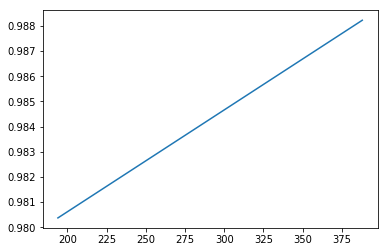

In [ ]:
learn.recorder.plot_metrics()

### Callback methods

You don't call these yourself - they're called by fastai's `callback` system automatically to enable the class's functionality.

In [ ]:
show_doc(Recorder.on_backward_begin)

#### <a id=on_backward_begin></a>`on_backward_begin`
> `on_backward_begin`(`smooth_loss`:`Tensor`, `kwargs`:`Any`)


Record the loss before any other callback has a chance to modify it. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L199">[source]</a>

In [ ]:
show_doc(Recorder.on_batch_begin)

#### <a id=on_batch_begin></a>`on_batch_begin`
> `on_batch_begin`(`kwargs`:`Any`)


Record learning rate and momentum at beginning of batch. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L194">[source]</a>

In [ ]:
show_doc(Recorder.on_epoch_end)

#### <a id=on_epoch_end></a>`on_epoch_end`
> `on_epoch_end`(`epoch`:`int`, `num_batch`:`int`, `smooth_loss`:`Tensor`, `last_metrics`=`'Collection'`, `kwargs`:`Any`) -> `bool`


Save epoch info: num_batch, smooth_loss, metrics. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L205">[source]</a>

In [ ]:
show_doc(Recorder.on_train_begin)

#### <a id=on_train_begin></a>`on_train_begin`
> `on_train_begin`(`pbar`:`PBar`, `metrics`:`MetricFuncList`, `kwargs`:`Any`)


Initialize recording status at beginning of training. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L187">[source]</a>

## Module functions

Generally you'll want to use a `Learner` to train your model, since they provide a lot of functionality and make things easier. However, for ultimate flexibility, you can call the same underlying functions that `Learner` calls behind the scenes.

In [ ]:
show_doc(fit)

#### <a id=fit></a>`fit`
> `fit`(`epochs`:`int`, `model`:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), `loss_fn`:`LossFunction`, `opt`:[`Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer), `data`:[`DataBunch`](/data.html#DataBunch), `callbacks`:`Optional`\[`Collection`\[[`Callback`](/callback.html#Callback)\]\]=`None`, `metrics`:`OptMetrics`=`None`)


Fit the `model` on `data` and learn using `loss` and `opt`. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L57">[source]</a>

Note that you have to create the `Optimizer` yourself if you call this function, whereas `Learn.fit` creates it for you automatically.

In [ ]:
show_doc(train_epoch)

#### <a id=train_epoch></a>`train_epoch`
> `train_epoch`(`model`:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), `dl`:[`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), `opt`:[`Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer), `loss_func`:`LossFunction`)


Simple training of `model` for 1 epoch of `dl` using optim `opt` and loss function `loss_func`. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L48">[source]</a>

You won't generally need to call this yourself - it's what `fit` calls for each epoch.

In [ ]:
show_doc(validate)

#### <a id=validate></a>`validate`
> `validate`(`model`:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), `dl`:[`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), `loss_fn`:`OptLossFunc`=`None`, `metrics`:`OptMetrics`=`None`, `cb_handler`:`Optional`\[[`CallbackHandler`](/callback.html#CallbackHandler)\]=`None`, `pbar`:`Union`\[`MasterBar`, `ProgressBar`, `NoneType`\]=`None`) -> `Iterator`\[`Tuple`\[`IntOrTensor`, `Ellipsis`\]\]


Calculate loss and metrics for the validation set. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L39">[source]</a>

This is what `fit` calls after each epoch. You can call it if you want to run inference on a `DataLoader` manually.

In [ ]:
show_doc(loss_batch)

#### <a id=loss_batch></a>`loss_batch`
> `loss_batch`(`model`:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), `xb`:`Tensor`, `yb`:`Tensor`, `loss_fn`:`OptLossFunc`=`None`, `opt`:`OptOptimizer`=`None`, `cb_handler`:`Optional`\[[`CallbackHandler`](/callback.html#CallbackHandler)\]=`None`, `metrics`:`OptMetrics`=`None`) -> `Tuple`\[`Union`\[`Tensor`, `int`, `float`, `str`\]\]


Calculate loss and metrics for a batch, call out to callbacks as necessary. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L15">[source]</a>

You won't generally need to call this yourself - it's what `fit` and `validate` call for each batch. It only does a backward pass if you set `opt`.

## Other classes

In [ ]:
show_doc(LearnerCallback, title_level=3)

### <a id=LearnerCallback></a>`class` `LearnerCallback`
> `LearnerCallback`(`learn`:[`Learner`](/basic_train.html#Learner)) :: [`Callback`](/callback.html#Callback)


Base class for creating callbacks for a [`Learner`](/basic_train.html#Learner). <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L171">[source]</a>

## Undocumented Methods - Methods moved below this line will intentionally be hidden

In [ ]:
show_doc(Learner.tta_only)

#### <a id=_tta_only></a>`_tta_only`
> `_tta_only`(`learn`:[`Learner`](/basic_train.html#Learner), `is_test`:`bool`=`False`, `scale`:`float`=`1.35`) -> `Iterator`\[`List`\[`Tensor`\]\]


Computes the outputs for several augmented inputs for TTA <a href="https://github.com/fastai/fastai/blob/master/fastai/tta.py#L23">[source]</a>

In [ ]:
show_doc(Learner.get_preds)

#### <a id=_learn_get_preds></a>`_learn_get_preds`
> `_learn_get_preds`(`learn`:[`Learner`](/basic_train.html#Learner), `is_test`:`bool`=`False`) -> `List`\[`Tensor`\]


Wrapper of get_preds for learner <a href="https://github.com/fastai/fastai/blob/master/fastai/tta.py#L18">[source]</a>

In [ ]:
show_doc(Learner.TTA)

#### <a id=_TTA></a>`_TTA`
> `_TTA`(`learn`:[`Learner`](/basic_train.html#Learner), `beta`:`float`=`0.4`, `scale`:`float`=`1.35`, `is_test`:`bool`=`False`) -> `Tensors`
<a href="https://github.com/fastai/fastai/blob/master/fastai/tta.py#L45">[source]</a>

In [ ]:
show_doc(Recorder.format_stats)

#### <a id=format_stats></a>`format_stats`
> `format_stats`(`stats`:`MetricsList`)


Format stats before printing. <a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L216">[source]</a>

In [ ]:
show_doc(Learner.loss_fn)

#### <a id=cross_entropy></a>`cross_entropy`
> `cross_entropy`(`input`, `target`, `weight`=`None`, `size_average`=`None`, `ignore_index`=`-100`, `reduce`=`None`, `reduction`=`'elementwise_mean'`)


function.

See :class:`~torch.nn.CrossEntropyLoss` for details.

Args:
    input (Tensor) : :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
        in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K > 1`
        in the case of K-dimensional loss.
    target (Tensor) : :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
        or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
        K-dimensional loss.
    weight (Tensor, optional): a manual rescaling weight given to each
        class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        some losses, there multiple elements per sample. If the field :attr:`size_average`
        is set to ``False``, the losses are instead summed for each minibatch. Ignored
        when reduce is ``False``. Default: ``True``
    ignore_index (int, optional): Specifies a target value that is ignored
        and does not contribute to the input gradient. When :attr:`size_average` is
        ``True``, the loss is averaged over non-ignored targets. Default: -100
    reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
        losses are averaged or summed over observations for each minibatch depending
        on :attr:`size_average`. When :attr:`reduce` is ``False``, returns a loss per
        batch element instead and ignores :attr:`size_average`. Default: ``True``
    reduction (string, optional): Specifies the reduction to apply to the output:
        'none' | 'elementwise_mean' | 'sum'. 'none': no reduction will be applied,
        'elementwise_mean': the sum of the output will be divided by the number of
        elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
        and :attr:`reduce` are in the process of being deprecated, and in the meantime,
        specifying either of those two args will override :attr:`reduction`. Default: 'elementwise_mean'

Examples::

    >>> input = torch.randn(3, 5, requires_grad=True)
    >>> target = torch.randint(5, (3,), dtype=torch.int64)
    >>> loss = F.cross_entropy(input, target)
    >>> loss.backward() 